# Asociační pravidla

### Dataset pro tuto metodu dolování dat

 Tento dataset patří pekárně "The Bread Basket" v Edinburghu. Dataset má 20 507 řádku a má 5 sloupců.
 Dataset obsahuje transakce zákazníků kteří objednali různé položky z pekárny online.

 https://www.kaggle.com/datasets/mittalvasu95/the-bread-basket?resource=download

Dataset se načte pomocí knihovny Pandas využitím funcke *read_csv()*

In [1]:
#nacteni knivony
import pandas as pd

df = pd.read_csv("datasets/bread-basket.csv")
df.head()

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,30-10-2016 09:58,morning,weekend
1,2,Scandinavian,30-10-2016 10:05,morning,weekend
2,2,Scandinavian,30-10-2016 10:05,morning,weekend
3,3,Hot chocolate,30-10-2016 10:07,morning,weekend
4,3,Jam,30-10-2016 10:07,morning,weekend


Knihovna pandas nabízí řadu užitečných funkcí které pomáhají prozkoumat daný dataset.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Transaction      20507 non-null  int64 
 1   Item             20507 non-null  object
 2   date_time        20507 non-null  object
 3   period_day       20507 non-null  object
 4   weekday_weekend  20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


In [3]:
df.nunique().sort_values()

weekday_weekend       2
period_day            4
Item                 94
date_time          9182
Transaction        9465
dtype: int64

In [4]:
print("Celkový počet transakcí je {} a počet jednotlivých položek z kterých se budou vytvářet asociačním pravidla je {}.".format(len(df['Transaction'].unique()), len(df['Item'].unique())))

Celkový počet transakcí je 9465 a počet jednotlivých položek z kterých se budou vytvářet asociačním pravidla je 94.


In [ ]:
#zda dataset obsahuje chybejici hodnoty
df.isna().sum()

Vizualizace 10 nejprodávanějších položek 

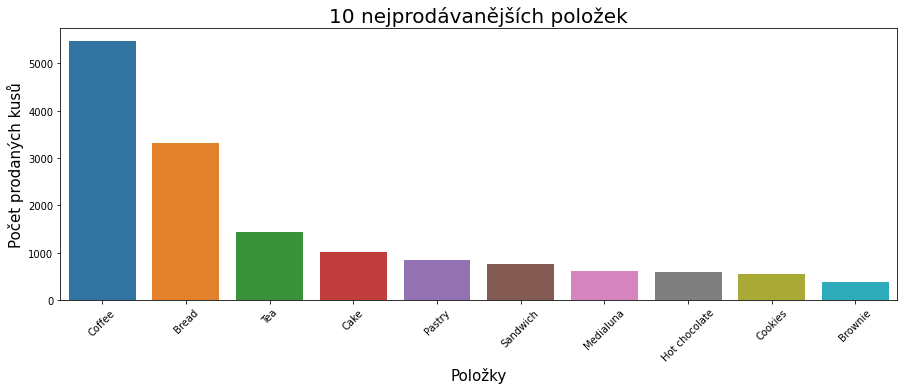

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,5))
sns.barplot(x = df.Item.value_counts().head(10).index, y = df.Item.value_counts().head(10).values)
plt.xlabel('Položky', size = 15)
plt.xticks(rotation=45)
plt.ylabel('Počet prodaných kusů', size = 15)
plt.title('10 nejprodávanějších položek', size = 20)
plt.show()

### Implementace Apriori 

Tento dataset je potřeba předzpracovat do vhodné podoby pro Apriori algoritmus. Dataset pomoci další funkce z knihovny Pandas *groupby()* je transformován na transakční tabulku která obsahuje 2 sloupce: číslo transakce a položky, které byly koupené v té transakci. Jednotlivé položky byly uložené jako *fronzenset*, aby usnadnili práci s množinami.

In [6]:
transaction_df = df.groupby(['Transaction'])['Item'].apply(frozenset).reset_index()
transaction_df.columns = ['Transaction', 'Item']
transaction_df

,Transaction,Item
0,1,(Bread)
1,2,(Scandinavian)
2,3,"(Jam, Cookies, Hot chocolate)"
3,4,(Muffin)
4,5,"(Pastry, Coffee, Bread)"
...,...,...
9460,9680,(Bread)
9461,9681,"(Truffles, Christmas common, Tea, Spanish Brunch)"
9462,9682,"(Muffin, Coffee, Tacos/Fajita, Tea)"
9463,9683,"(Pastry, Coffee)"


In [7]:
transactions = transaction_df['Item']
transaction_dict = transactions.to_dict()

Zde se vytvoří množina frektentovaných vzorů, které mají jen jednu položku, které splňují minimální podporu. Zde minimální podpora byla zvolena 1%, aby jsme dostali nějaké zajímavé asociační pravidla

In [8]:
#funkce na vyvoreni kandidatni mnoziny 1-prvkovych polozek, ktere splnuji minimalni podporu 
def get_k_1_itemset(min_support = 0.5, frequent_itemsets = {}, transactions=None):
    #vytvari se vsechny kanditaty
    count = {}
    for items in transactions:
        for item in items:
            if item in count:
                count[item] += 1
            else:
                count[item] = 1
    #odstrani se polozky, ktere nesplnuji minimalni podporu
    list_of_items_not_min = []
    for item_count in count:
        count[item_count] = float(count[item_count]/len(transactions))
        if count[item_count] <= min_support:
            list_of_items_not_min.append(item_count)
    for item_eliminate in list_of_items_not_min:
        count.pop(item_eliminate)
    #vytvori se mnozina polozek, ktere splnuji minimalni podporu
    l1 = {}
    for key in count:
        l1[frozenset([key])] = count[key]
    
    frequent_itemsets[1] = l1

In [9]:

frequent_itemsets = {}
min_support = 0.01 # 1%

get_k_1_itemset(min_support, frequent_itemsets, transactions)


In [10]:
from collections import defaultdict
#funkce pro hledani frektventovane mnoziny
def find_frequent_itemsets(transactions_dict, k_1_itemsets, min_support):
    counter = defaultdict(int)
    for transactions_id, items in transactions.items():
        for itemset in k_1_itemsets:
            if itemset.issubset(items):
                for other_items in items - itemset:
                    current_superset = itemset | frozenset((other_items,))
                    counter[current_superset] += 1
    for i in counter:
        counter[i] = float(counter[i]/len(transactions))
    
    new_dict = {}
    for itemset, f in counter.items():
        if f >= min_support:
            new_dict[itemset] = f
    return new_dict

In [11]:
import sys
#cyklus pro vytvoreni frekventovanych mnozin o velikosti k, skonci kdyz aktualni frekventovana mnozina je 0
print("Zde je {} položek, které splňují minimální podporu {} %".format(len(frequent_itemsets[1]), (min_support*100)))
sys.stdout.flush()
k = 2 
while True:
    cur_frequent_itemsets = find_frequent_itemsets(transaction_dict, frequent_itemsets[k-1], min_support)
    if len(cur_frequent_itemsets) == 0:
        print("Nenašla se žádná frekventovaná množina o velikosti  {}".format(k))
        sys.stdout.flush()
        break
    else:
        print("Našlo se {} frekventovanývh množin o velikosti {}".format(len(cur_frequent_itemsets), k))
        sys.stdout.flush()
        frequent_itemsets[k] = cur_frequent_itemsets
    k += 1
#odstraneni mnoziny L1
del frequent_itemsets[1]

Zde je 30 položek, které splňují minimální podporu 1.0 %
Našlo se 66 frekventovanývh množin o velikosti 2
Našlo se 27 frekventovanývh množin o velikosti 3
Nenašla se žádná frekventovaná množina o velikosti  4


In [12]:
candidate_rules = []
#vytvoreni asociacnich pravidel z frekvetovane mnozine ve tvaru A->B
for itemset_length, itemset_counts in frequent_itemsets.items():
    for itemset in itemset_counts.keys():
        for B in itemset:
            A = itemset - set((B,))
            candidate_rules.append((A,B))
print("Je zde {} pravidel".format(len(candidate_rules)))

Je zde 213 pravidel


In [13]:
correct_counts = defaultdict(int)
incorrect_counts = defaultdict(int)
#pokud A i B patri do stejne frekventovane mnoziny, tak se vytvori spravne pravidlo, jinak je spatne. Soucet spravnych pravidel a spatnych vytvori S(A). 
for transactions_id, items in transaction_dict.items():
    for candidate_rule in candidate_rules:
        A,B = candidate_rule
        if A.issubset(items):
            if B in items:
                correct_counts[candidate_rule] += 1
            else:
                incorrect_counts[candidate_rule] += 1
#pocita se podpora pro jednotlive pravidla na zaklade vzorce s(A U B)/s(A), kde s(A U B) je pocet vyskytu 
rule_confidence = {candidate_rule: correct_counts[candidate_rule] / float(correct_counts[candidate_rule] + incorrect_counts[candidate_rule]) for candidate_rule in candidate_rules}

In [14]:
from operator import itemgetter
sorted_confidence = sorted(rule_confidence.items(), key=itemgetter(1), reverse=True)


Vypis devíti pravidel s nejvetsi spolehlivosti a minimalni podporou 1%

In [17]:
for index in range(9):
    (A,B) = sorted_confidence[index][0]
    print("Pravidlo {0}: {1} -> {2} | spolehlivost : {3:.3f}".format(index+1, [x for x in A], B, rule_confidence[(A,B)]))

Pravidlo 1: ['Toast'] -> Coffee | spolehlivost : 0.704
Pravidlo 2: ['Cake', 'Sandwich'] -> Coffee | spolehlivost : 0.677
Pravidlo 3: ['Pastry', 'Hot chocolate'] -> Coffee | spolehlivost : 0.667
Pravidlo 4: ['Soup', 'Sandwich'] -> Coffee | spolehlivost : 0.654
Pravidlo 5: ['Salad'] -> Coffee | spolehlivost : 0.626
Pravidlo 6: ['Cookies', 'Hot chocolate'] -> Coffee | spolehlivost : 0.614
Pravidlo 7: ['Juice', 'Cookies'] -> Coffee | spolehlivost : 0.603
Pravidlo 8: ['Cake', 'Hot chocolate'] -> Coffee | spolehlivost : 0.602
Pravidlo 9: ['Spanish Brunch'] -> Coffee | spolehlivost : 0.599


## Použití knihovny mlxtend

In [18]:
from mlxtend.frequent_patterns import apriori, association_rules

Dataset je potřeba předzpracovat na vhodnou podobu pro funkci _apriori()_ z knihovny mlxtend, která má tvar _pandas.Dataframu_ ve tvaru MxN, kde M je počet transakcí a N jsou všechny dostupné položky a každá buňka má True hodnotu pokud je položka součástí transakce

In [19]:
xtend_basket_data = df.groupby(['Transaction', 'Item'])['Item'].count().reset_index(name='Count')
xtend_data = xtend_basket_data.pivot_table(index='Transaction', columns='Item', values='Count', aggfunc='sum').fillna(0)
xtend_data.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:

def one_hot_encode(x):
    if x >= 1:
        return True
    if x <= 0:
        return False

In [21]:
xtend_data = xtend_data.applymap(one_hot_encode)
xtend_data.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### mlxtend implementace algoritmu apriori

In [22]:
#vytvoreni frekventovanych mnozin pomoci Apriori
fitems = apriori(xtend_data, min_support = 0.01, use_colnames = True)
#vysledek je klasicky DataFrame, ktery je mozne upravit, zde je pridano sloupec s delkou frekventovane mnoziny
fitems['lenght'] = fitems['itemsets'].apply(lambda x: len(x))
fitems

,support,itemsets,lenght
0,0.036344,(Alfajores),1
1,0.016059,(Baguette),1
2,0.327205,(Bread),1
3,0.040042,(Brownie),1
4,0.103856,(Cake),1
...,...,...,...
56,0.023666,"(Toast, Coffee)",2
57,0.014369,"(Tea, Sandwich)",2
58,0.010037,"(Cake, Coffee, Bread)",3
59,0.011199,"(Pastry, Coffee, Bread)",3


In [23]:
#vytvoreni pravidel z frekventovanych mnozin vytvorene pomoci algoritmu Apriori
rules = association_rules(fitems, metric='confidence', min_threshold=0.3)
#upraveni dataFrame, aby se zobrazili pravidla sestupne podle metriky spolehlivosti
rules = rules.sort_values(by=['confidence'], ascending=False)
rules = rules.reset_index(drop=True)
rules = rules[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence']]
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence
0,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403
1,(Spanish Brunch),(Coffee),0.018172,0.478394,0.010882,0.598837
2,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231
3,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147
4,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698
5,(Juice),(Coffee),0.038563,0.478394,0.020602,0.534247
6,(Sandwich),(Coffee),0.071844,0.478394,0.038246,0.532353
7,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958
8,(Scone),(Coffee),0.034548,0.478394,0.018067,0.522936
9,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447


### mlxtend implementace FP-growth 

In [24]:
from mlxtend.frequent_patterns import fpgrowth

#vytvoreni frekventovanych mnozin pomoci FP-growth
fitems_fpg = fpgrowth(xtend_data, min_support = 0.01, use_colnames=True)
fitems_fpg

,support,itemsets
0,0.327205,(Bread)
1,0.029054,(Scandinavian)
2,0.058320,(Hot chocolate)
3,0.054411,(Cookies)
4,0.015003,(Jam)
...,...,...
56,0.019651,"(Brownie, Coffee)"
57,0.010777,"(Brownie, Bread)"
58,0.023666,"(Toast, Coffee)"
59,0.018067,"(Coffee, Scone)"


In [25]:
#vytvoreni pravidel z frekventovanych mnozin vytvorene pomoci algoritmu FP-grow
rules_fpg = association_rules(fitems_fpg, min_threshold=0.3)
#upraveni dataFrame, aby se zobrazili pravidla sestupne podle metriky spolehlivosti
rules_fpg = rules_fpg.sort_values(by=['confidence'], ascending=False)
rules_fpg = rules_fpg.reset_index(drop=True)
rules_fpg = rules_fpg[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence']]
rules_fpg

,antecedents,consequents,antecedent support,consequent support,support,confidence
0,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403
1,(Spanish Brunch),(Coffee),0.018172,0.478394,0.010882,0.598837
2,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231
3,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147
4,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698
5,(Juice),(Coffee),0.038563,0.478394,0.020602,0.534247
6,(Sandwich),(Coffee),0.071844,0.478394,0.038246,0.532353
7,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958
8,(Scone),(Coffee),0.034548,0.478394,0.018067,0.522936
9,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447


 ### časové porovnání dvou algoritmu pro hledání množin frekventovaný vzoru

In [26]:
%timeit -n 100 -r 10 apriori(xtend_data, min_support = 0.01)


13.6 ms ± 297 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [27]:
%timeit -n 100 -r 10 fpgrowth(xtend_data, min_support = 0.01)

32.2 ms ± 736 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


* FP-grow by mel byt radove rychlejsi, ale zde je opakem, kde je radove pomalejsi

## Použití knihovny PyCaret

In [28]:
from pycaret.arules import *

In [29]:
#zpracovani datasetu, nastaveni atrubutu Transakce a nastaveni atributu polozka
exp = setup(data=df, transaction_id='Transaction', item_id='Item')

Description,Value
session_id,7620
# Transactions,9465
# Items,94
Ignore Items,None


In [30]:
#vytvoreni pravidel
model1 = create_model(metric="confidence", min_support=0.01, threshold=0.3)
model1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Toast),(Coffee),0.0336,0.4784,0.0237,0.7044,1.4724,0.0076,1.7646
1,(Spanish Brunch),(Coffee),0.0182,0.4784,0.0109,0.5988,1.2518,0.0022,1.3002
2,(Medialuna),(Coffee),0.0618,0.4784,0.0352,0.5692,1.1899,0.0056,1.2109
3,(Pastry),(Coffee),0.0861,0.4784,0.0475,0.5521,1.1542,0.0064,1.1647
4,(Alfajores),(Coffee),0.0363,0.4784,0.0197,0.5407,1.1302,0.0023,1.1356
5,(Juice),(Coffee),0.0386,0.4784,0.0206,0.5342,1.1167,0.0022,1.1199
6,(Sandwich),(Coffee),0.0718,0.4784,0.0382,0.5324,1.1128,0.0039,1.1154
7,(Cake),(Coffee),0.1039,0.4784,0.0547,0.5270,1.1015,0.0050,1.1027
8,(Scone),(Coffee),0.0345,0.4784,0.0181,0.5229,1.0931,0.0015,1.0934
9,(Cookies),(Coffee),0.0544,0.4784,0.0282,0.5184,1.0837,0.0022,1.0832


In [31]:
#vykresleni pravidel
plot_model(model1, plot='2d', scale=0.75)

PyCaret knihovna nabízí funkci _get_rules()_, která kombinuje předchozí dvě funkce v jednu

In [33]:
rules = get_rules(df, transaction_id='Transaction', item_id='Item', min_support=0.01, metric="confidence", threshold=0.3)
rules

Description,Value
session_id,844
# Transactions,9465
# Items,94
Ignore Items,None


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Toast),(Coffee),0.0336,0.4784,0.0237,0.7044,1.4724,0.0076,1.7646
1,(Spanish Brunch),(Coffee),0.0182,0.4784,0.0109,0.5988,1.2518,0.0022,1.3002
2,(Medialuna),(Coffee),0.0618,0.4784,0.0352,0.5692,1.1899,0.0056,1.2109
3,(Pastry),(Coffee),0.0861,0.4784,0.0475,0.5521,1.1542,0.0064,1.1647
4,(Alfajores),(Coffee),0.0363,0.4784,0.0197,0.5407,1.1302,0.0023,1.1356
5,(Juice),(Coffee),0.0386,0.4784,0.0206,0.5342,1.1167,0.0022,1.1199
6,(Sandwich),(Coffee),0.0718,0.4784,0.0382,0.5324,1.1128,0.0039,1.1154
7,(Cake),(Coffee),0.1039,0.4784,0.0547,0.5270,1.1015,0.0050,1.1027
8,(Scone),(Coffee),0.0345,0.4784,0.0181,0.5229,1.0931,0.0015,1.0934
9,(Cookies),(Coffee),0.0544,0.4784,0.0282,0.5184,1.0837,0.0022,1.0832


In [34]:
plot_model(rules, scale=0.75, plot='3d')